In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
pd.set_option('display.max_columns', None)
from shapely.geometry import Point
import fiona
import math

In [90]:
stores_2022 = pd.read_csv('/srv/data/my_shared_data_folder/rafi/2022_Business_Academic_QCQ_grocery.csv')
stores_2022.drop(['Unnamed: 0'],inplace=True,axis=1)
territories = ['PR', 'FM', 'MP', 'GU', 'VI', 'MH']
stores_2022 = stores_2022.drop(stores_2022[stores_2022['STATE'].isin(territories)].index)

In [91]:
#Filter Grocery stores by sic (starting with 5411)
grocery_sic = stores_2022.loc[stores_2022[['PRIMARY SIC CODE', 'SIC CODE', 'SIC CODE 1', 'SIC CODE 2', 'SIC CODE 3', 'SIC CODE 4']].astype(str).apply(lambda x: x.str.startswith('5411')).any(axis=1)]
grocery_sic.head()

,COMPANY,ADDRESS LINE 1,CITY,STATE,ZIPCODE,ZIP4,COUNTY CODE,AREA CODE,IDCODE,LOCATION EMPLOYEE SIZE CODE,LOCATION SALES VOLUME CODE,PRIMARY SIC CODE,SIC6_DESCRIPTIONS,PRIMARY NAICS CODE,NAICS8 DESCRIPTIONS,SIC CODE,SIC6_DESCRIPTIONS (SIC),SIC CODE 1,SIC6_DESCRIPTIONS (SIC1),SIC CODE 2,SIC6_DESCRIPTIONS(SIC2),SIC CODE 3,SIC6_DESCRIPTIONS(SIC3),SIC CODE 4,SIC6_DESCRIPTIONS(SIC4),ARCHIVE VERSION YEAR,YELLOW PAGE CODE,EMPLOYEE SIZE (5) - LOCATION,SALES VOLUME (9) - LOCATION,BUSINESS STATUS CODE,INDUSTRY SPECIFIC FIRST BYTE,YEAR ESTABLISHED,OFFICE SIZE CODE,COMPANY HOLDING STATUS,ABI,SUBSIDIARY NUMBER,PARENT NUMBER,PARENT ACTUAL EMPLOYEE SIZE,PARENT ACTUAL SALES VOLUME,PARENT EMPLOYEE SIZE CODE,PARENT SALES VOLUME CODE,SITE NUMBER,ADDRESS TYPE INDICATOR,POPULATION CODE,CENSUS TRACT,CENSUS BLOCK,LATITUDE,LONGITUDE,MATCH CODE,CBSA CODE,CBSA LEVEL,CSA CODE,FIPS CODE
0,GOMART,55 POSTAL PLZ,MORGANTOWN,WV,26508,7005.0,61.0,304,2,C,C,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,554101.0,SERVICE STATIONS-GASOLINE & OIL,554110.0,ALTERNATIVE FUELS,NaN,NaN,NaN,NaN,NaN,NaN,2022,21303.0,13.0,2482.0,2,NaN,NaN,NaN,NaN,998372387,NaN,124929449.0,50.0,389500.0,E,I,998372387.0,NaN,7,11000.0,3.0,39.594376,-79.954437,P,34060.0,2.0,390.0,54061.0
1,7-ELEVEN,485 E MAIN ST,EL CENTRO,CA,92243,2619.0,25.0,760,2,B,C,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,554101.0,SERVICE STATIONS-GASOLINE & OIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,6.0,1273.0,2,W,NaN,NaN,NaN,495660326,NaN,5863311.0,800.0,1272634.0,H,K,495660326.0,NaN,7,11400.0,3.0,32.792679,-115.536058,0,20940.0,2.0,0.0,6025.0
2,EL SOL MARKET,110 W MAIN ST,WESTMORLAND,CA,92281,NaN,25.0,760,2,B,C,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,5.0,1061.0,9,NaN,NaN,NaN,NaN,519605455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,10200.0,1.0,33.051800,-115.581800,X,20940.0,2.0,0.0,6025.0
3,COOL SPRINGS GROCERY,241 WILDWOOD ST,MORGANTOWN,WV,26505,3141.0,61.0,304,2,A,A,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,2.0,382.0,9,NaN,NaN,NaN,NaN,817953730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,10400.0,4.0,39.652885,-79.986398,P,34060.0,2.0,390.0,54061.0
4,CIRCLE K,123 E MAIN ST,WESTMORLAND,CA,92281,NaN,25.0,760,2,B,C,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,554101.0,SERVICE STATIONS-GASOLINE & OIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,6.0,1273.0,2,F,NaN,NaN,NaN,855113817,NaN,450720289.0,650.0,4981020.0,H,J,NaN,NaN,3,10200.0,1.0,33.051800,-115.581800,X,20940.0,2.0,0.0,6025.0


In [92]:
grocery_t10_22 = grocery_sic.groupby('PARENT NUMBER', dropna=False).size().reset_index(name='COUNT')
grocery_t10_22.sort_values('COUNT', ascending=False, inplace=True)
grocery_t10_22.reset_index(drop=True,inplace=True)

# Create other row
other_row = grocery_t10_22.iloc[11:]
other_column = other_row['COUNT'].sum()

# Remove other rows
grocery_t10_22 = grocery_t10_22.iloc[:11]
grocery_t10_22.loc[len(grocery_t10_22)] = ["Other", other_column]

#grocery_t10_22.reset_index(drop=True, inplace=True)  # Reset index to start from 0

grocery_t10_22['PARENT NUMBER'] = grocery_t10_22['PARENT NUMBER'].astype(str)
grocery_t10_22['Percent'] = grocery_t10_22['COUNT'] / len(grocery_sic) * 100

grocery_t10_22.head()


,PARENT NUMBER,COUNT,Percent
0,nan,77818,49.287773
1,5863311.0,11939,7.561833
2,450720289.0,6814,4.315799
3,5889993.0,4397,2.784938
4,7521503.0,3574,2.263673


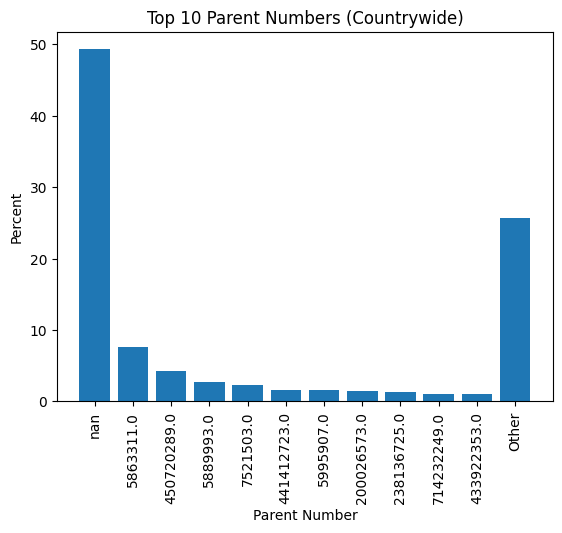

In [93]:
#Top 10 Parent (Country)
plt.bar(grocery_t10_22['PARENT NUMBER'], grocery_t10_22['Percent'])
plt.xlabel('Parent Number')
plt.ylabel('Percent')
plt.title('Top 10 Parent Numbers (Countrywide)')
plt.xticks(rotation=90)
plt.show()

In [94]:
grocery_sic['GEOMETRY'] = [Point(xy) for xy in zip(grocery_sic.LONGITUDE, grocery_sic.LATITUDE)]
grocery22_gdf = gpd.GeoDataFrame(grocery_sic, geometry='GEOMETRY')
grocery22_gdf.set_crs('epsg:4326', inplace=True)  

/tmp/ipykernel_589413/140022936.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grocery_sic['GEOMETRY'] = [Point(xy) for xy in zip(grocery_sic.LONGITUDE, grocery_sic.LATITUDE)]


,COMPANY,ADDRESS LINE 1,CITY,STATE,ZIPCODE,ZIP4,COUNTY CODE,AREA CODE,IDCODE,LOCATION EMPLOYEE SIZE CODE,LOCATION SALES VOLUME CODE,PRIMARY SIC CODE,SIC6_DESCRIPTIONS,PRIMARY NAICS CODE,NAICS8 DESCRIPTIONS,SIC CODE,SIC6_DESCRIPTIONS (SIC),SIC CODE 1,SIC6_DESCRIPTIONS (SIC1),SIC CODE 2,SIC6_DESCRIPTIONS(SIC2),SIC CODE 3,SIC6_DESCRIPTIONS(SIC3),SIC CODE 4,SIC6_DESCRIPTIONS(SIC4),ARCHIVE VERSION YEAR,YELLOW PAGE CODE,EMPLOYEE SIZE (5) - LOCATION,SALES VOLUME (9) - LOCATION,BUSINESS STATUS CODE,INDUSTRY SPECIFIC FIRST BYTE,YEAR ESTABLISHED,OFFICE SIZE CODE,COMPANY HOLDING STATUS,ABI,SUBSIDIARY NUMBER,PARENT NUMBER,PARENT ACTUAL EMPLOYEE SIZE,PARENT ACTUAL SALES VOLUME,PARENT EMPLOYEE SIZE CODE,PARENT SALES VOLUME CODE,SITE NUMBER,ADDRESS TYPE INDICATOR,POPULATION CODE,CENSUS TRACT,CENSUS BLOCK,LATITUDE,LONGITUDE,MATCH CODE,CBSA CODE,CBSA LEVEL,CSA CODE,FIPS CODE,GEOMETRY
0,GOMART,55 POSTAL PLZ,MORGANTOWN,WV,26508,7005.0,61.0,304,2,C,C,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,554101.0,SERVICE STATIONS-GASOLINE & OIL,554110.0,ALTERNATIVE FUELS,NaN,NaN,NaN,NaN,NaN,NaN,2022,21303.0,13.0,2482.0,2,NaN,NaN,NaN,NaN,998372387,NaN,124929449.0,50.0,389500.0,E,I,998372387.0,NaN,7,11000.0,3.0,39.594376,-79.954437,P,34060.0,2.0,390.0,54061.0,POINT (-79.95444 39.59438)
1,7-ELEVEN,485 E MAIN ST,EL CENTRO,CA,92243,2619.0,25.0,760,2,B,C,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,554101.0,SERVICE STATIONS-GASOLINE & OIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,6.0,1273.0,2,W,NaN,NaN,NaN,495660326,NaN,5863311.0,800.0,1272634.0,H,K,495660326.0,NaN,7,11400.0,3.0,32.792679,-115.536058,0,20940.0,2.0,0.0,6025.0,POINT (-115.53606 32.79268)
2,EL SOL MARKET,110 W MAIN ST,WESTMORLAND,CA,92281,NaN,25.0,760,2,B,C,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,5.0,1061.0,9,NaN,NaN,NaN,NaN,519605455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,10200.0,1.0,33.051800,-115.581800,X,20940.0,2.0,0.0,6025.0,POINT (-115.58180 33.05180)
3,COOL SPRINGS GROCERY,241 WILDWOOD ST,MORGANTOWN,WV,26505,3141.0,61.0,304,2,A,A,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,2.0,382.0,9,NaN,NaN,NaN,NaN,817953730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,10400.0,4.0,39.652885,-79.986398,P,34060.0,2.0,390.0,54061.0,POINT (-79.98640 39.65288)
4,CIRCLE K,123 E MAIN ST,WESTMORLAND,CA,92281,NaN,25.0,760,2,B,C,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,554101.0,SERVICE STATIONS-GASOLINE & OIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,6.0,1273.0,2,F,NaN,NaN,NaN,855113817,NaN,450720289.0,650.0,4981020.0,H,J,NaN,NaN,3,10200.0,1.0,33.051800,-115.581800,X,20940.0,2.0,0.0,6025.0,POINT (-115.58180 33.05180)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203497,T-MART,103 SUNRISE DR,SUNRISE BEACH,TX,78643,9287.0,299.0,325,2,A,A,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,343201.0,PLUMBING FIXTURES & SUPPLIES-MFRS,572222.0,PUMPS-RETAIL,508444.0,PUMPS (WHLS),525104.0,HARDWARE-RETAIL,594131.0,FISHING TACKLE-DEALERS,2022,NaN,2.0,441.0,9,NaN,NaN,NaN,NaN,880617683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,970300.0,1.0,30.593381,-98.425843,P,0.0,NaN,0.0,48299.0,POINT (-98.42584 30.59338)
203498,H-E-B,1434 W WELLS BRANCH PKWY,PFLUGERVILLE,TX,78660,3153.0,453.0,512,2,G,H,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,554101.0,SERVICE STATIONS-GASOLINE & OIL,729954.0,VEHICLE & DRIVERS LICENSING SERVICES,581208.0,RESTAURANTS,NaN,NaN,NaN,NaN,2022,39106.0,270.0,71857.0,2,F,NaN,NaN,NaN,403451198,NaN,436443592.0,1000.0,23000000.0,I,K,403451198.0,NaN,8,1840.0,3.0,30.442331,-97.664580,P,12420.0,2.0,0.0,48453.0,POINT (-97.66458 30.44233)
203500,SAC N PAC,2101 N STATE HIGHWAY 123,SAN MA

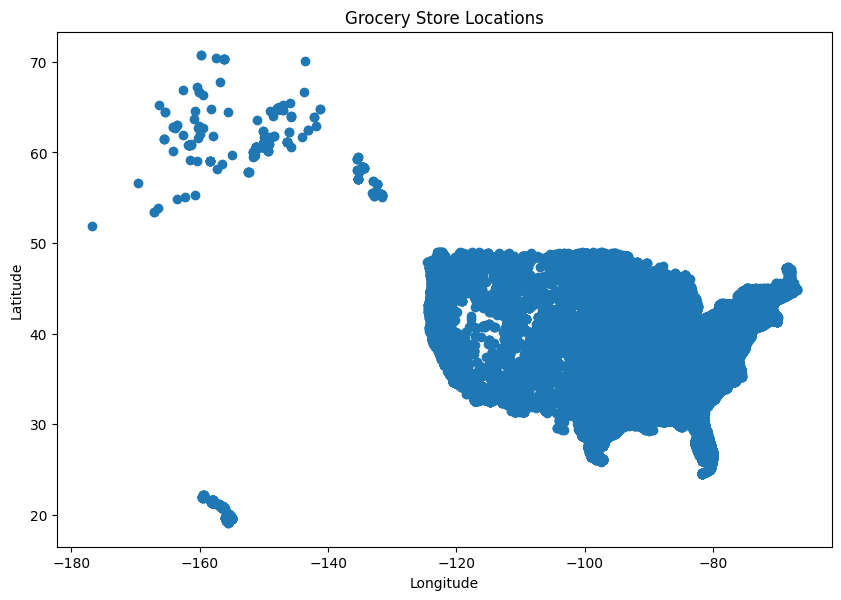

In [95]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')

grocery22_gdf.plot(ax=ax)
ax.set_title('Grocery Store Locations')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()


In [96]:
grocery22_gdf["TOP TEN"] = grocery22_gdf['PARENT NUMBER'].apply(lambda x: '5863311.0' in str(x) or '450720289.0' in str(x) or '5889993.0' in str(x)or '7521503.0' in str(x)or '441412723.0' in str(x) or '5995907.0' in str(x) or '200026573.0' in str(x)or '238136725.0' in str(x)or '714232249.0' in str(x) or '433922353.0' in str(x))


In [97]:
grocery22_gdf.loc[:, "INDEPENDENT STORE"] = False
grocery22_gdf.loc[(grocery_sic['PARENT NUMBER'].isna()), 'INDEPENDENT STORE'] = True
grocery22_gdf.head()

,COMPANY,ADDRESS LINE 1,CITY,STATE,ZIPCODE,ZIP4,COUNTY CODE,AREA CODE,IDCODE,LOCATION EMPLOYEE SIZE CODE,LOCATION SALES VOLUME CODE,PRIMARY SIC CODE,SIC6_DESCRIPTIONS,PRIMARY NAICS CODE,NAICS8 DESCRIPTIONS,SIC CODE,SIC6_DESCRIPTIONS (SIC),SIC CODE 1,SIC6_DESCRIPTIONS (SIC1),SIC CODE 2,SIC6_DESCRIPTIONS(SIC2),SIC CODE 3,SIC6_DESCRIPTIONS(SIC3),SIC CODE 4,SIC6_DESCRIPTIONS(SIC4),ARCHIVE VERSION YEAR,YELLOW PAGE CODE,EMPLOYEE SIZE (5) - LOCATION,SALES VOLUME (9) - LOCATION,BUSINESS STATUS CODE,INDUSTRY SPECIFIC FIRST BYTE,YEAR ESTABLISHED,OFFICE SIZE CODE,COMPANY HOLDING STATUS,ABI,SUBSIDIARY NUMBER,PARENT NUMBER,PARENT ACTUAL EMPLOYEE SIZE,PARENT ACTUAL SALES VOLUME,PARENT EMPLOYEE SIZE CODE,PARENT SALES VOLUME CODE,SITE NUMBER,ADDRESS TYPE INDICATOR,POPULATION CODE,CENSUS TRACT,CENSUS BLOCK,LATITUDE,LONGITUDE,MATCH CODE,CBSA CODE,CBSA LEVEL,CSA CODE,FIPS CODE,GEOMETRY,TOP TEN,INDEPENDENT STORE
0,GOMART,55 POSTAL PLZ,MORGANTOWN,WV,26508,7005.0,61.0,304,2,C,C,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,554101.0,SERVICE STATIONS-GASOLINE & OIL,554110.0,ALTERNATIVE FUELS,NaN,NaN,NaN,NaN,NaN,NaN,2022,21303.0,13.0,2482.0,2,NaN,NaN,NaN,NaN,998372387,NaN,124929449.0,50.0,389500.0,E,I,998372387.0,NaN,7,11000.0,3.0,39.594376,-79.954437,P,34060.0,2.0,390.0,54061.0,POINT (-79.95444 39.59438),False,False
1,7-ELEVEN,485 E MAIN ST,EL CENTRO,CA,92243,2619.0,25.0,760,2,B,C,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,554101.0,SERVICE STATIONS-GASOLINE & OIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,6.0,1273.0,2,W,NaN,NaN,NaN,495660326,NaN,5863311.0,800.0,1272634.0,H,K,495660326.0,NaN,7,11400.0,3.0,32.792679,-115.536058,0,20940.0,2.0,0.0,6025.0,POINT (-115.53606 32.79268),True,False
2,EL SOL MARKET,110 W MAIN ST,WESTMORLAND,CA,92281,NaN,25.0,760,2,B,C,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,5.0,1061.0,9,NaN,NaN,NaN,NaN,519605455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,10200.0,1.0,33.051800,-115.581800,X,20940.0,2.0,0.0,6025.0,POINT (-115.58180 33.05180),False,True
3,COOL SPRINGS GROCERY,241 WILDWOOD ST,MORGANTOWN,WV,26505,3141.0,61.0,304,2,A,A,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,2.0,382.0,9,NaN,NaN,NaN,NaN,817953730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,10400.0,4.0,39.652885,-79.986398,P,34060.0,2.0,390.0,54061.0,POINT (-79.98640 39.65288),False,True
4,CIRCLE K,123 E MAIN ST,WESTMORLAND,CA,92281,NaN,25.0,760,2,B,C,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,554101.0,SERVICE STATIONS-GASOLINE & OIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,6.0,1273.0,2,F,NaN,NaN,NaN,855113817,NaN,450720289.0,650.0,4981020.0,H,J,NaN,NaN,3,10200.0,1.0,33.051800,-115.581800,X,20940.0,2.0,0.0,6025.0,POINT (-115.58180 33.05180),True,False


In [98]:
grocery22_gdf.drop(["TOP TEN","INDEPENDENT STORE"],inplace=True,axis=1)

In [116]:
def store_type(row):
    '''Based on the country T10 parent number's assigns each company to the group TOP TEN, INDEPENDENT STORE, or OTHER'''
    top_ten = [5863311.0, 450720289.0, 5889993.0, 7521503.0, 441412723.0, 5995907.0, 200026573.0, 238136725.0, 714232249.0, 433922353.0]
    
    parent_num = row['PARENT NUMBER']  
    
    if parent_num in top_ten:
        return 'TOP TEN'
    if math.isnan(parent_num):
        return 'INDEPENDENT STORE'
    
    return 'OTHER'

grocery22_gdf['STORE TYPE'] = grocery22_gdf.apply(store_type, axis=1)
grocery22_gdf.head()

,COMPANY,ADDRESS LINE 1,CITY,STATE,ZIPCODE,ZIP4,COUNTY CODE,AREA CODE,IDCODE,LOCATION EMPLOYEE SIZE CODE,LOCATION SALES VOLUME CODE,PRIMARY SIC CODE,SIC6_DESCRIPTIONS,PRIMARY NAICS CODE,NAICS8 DESCRIPTIONS,SIC CODE,SIC6_DESCRIPTIONS (SIC),SIC CODE 1,SIC6_DESCRIPTIONS (SIC1),SIC CODE 2,SIC6_DESCRIPTIONS(SIC2),SIC CODE 3,SIC6_DESCRIPTIONS(SIC3),SIC CODE 4,SIC6_DESCRIPTIONS(SIC4),ARCHIVE VERSION YEAR,YELLOW PAGE CODE,EMPLOYEE SIZE (5) - LOCATION,SALES VOLUME (9) - LOCATION,BUSINESS STATUS CODE,INDUSTRY SPECIFIC FIRST BYTE,YEAR ESTABLISHED,OFFICE SIZE CODE,COMPANY HOLDING STATUS,ABI,SUBSIDIARY NUMBER,PARENT NUMBER,PARENT ACTUAL EMPLOYEE SIZE,PARENT ACTUAL SALES VOLUME,PARENT EMPLOYEE SIZE CODE,PARENT SALES VOLUME CODE,SITE NUMBER,ADDRESS TYPE INDICATOR,POPULATION CODE,CENSUS TRACT,CENSUS BLOCK,LATITUDE,LONGITUDE,MATCH CODE,CBSA CODE,CBSA LEVEL,CSA CODE,FIPS CODE,GEOMETRY,STORE TYPE
0,GOMART,55 POSTAL PLZ,MORGANTOWN,WV,26508,7005.0,61.0,304,2,C,C,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,554101.0,SERVICE STATIONS-GASOLINE & OIL,554110.0,ALTERNATIVE FUELS,NaN,NaN,NaN,NaN,NaN,NaN,2022,21303.0,13.0,2482.0,2,NaN,NaN,NaN,NaN,998372387,NaN,124929449.0,50.0,389500.0,E,I,998372387.0,NaN,7,11000.0,3.0,39.594376,-79.954437,P,34060.0,2.0,390.0,54061.0,POINT (-79.95444 39.59438),OTHER
1,7-ELEVEN,485 E MAIN ST,EL CENTRO,CA,92243,2619.0,25.0,760,2,B,C,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,554101.0,SERVICE STATIONS-GASOLINE & OIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,6.0,1273.0,2,W,NaN,NaN,NaN,495660326,NaN,5863311.0,800.0,1272634.0,H,K,495660326.0,NaN,7,11400.0,3.0,32.792679,-115.536058,0,20940.0,2.0,0.0,6025.0,POINT (-115.53606 32.79268),TOP TEN
2,EL SOL MARKET,110 W MAIN ST,WESTMORLAND,CA,92281,NaN,25.0,760,2,B,C,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,5.0,1061.0,9,NaN,NaN,NaN,NaN,519605455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,10200.0,1.0,33.051800,-115.581800,X,20940.0,2.0,0.0,6025.0,POINT (-115.58180 33.05180),INDEPENDENT STORE
3,COOL SPRINGS GROCERY,241 WILDWOOD ST,MORGANTOWN,WV,26505,3141.0,61.0,304,2,A,A,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,2.0,382.0,9,NaN,NaN,NaN,NaN,817953730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,10400.0,4.0,39.652885,-79.986398,P,34060.0,2.0,390.0,54061.0,POINT (-79.98640 39.65288),INDEPENDENT STORE
4,CIRCLE K,123 E MAIN ST,WESTMORLAND,CA,92281,NaN,25.0,760,2,B,C,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,554101.0,SERVICE STATIONS-GASOLINE & OIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,6.0,1273.0,2,F,NaN,NaN,NaN,855113817,NaN,450720289.0,650.0,4981020.0,H,J,NaN,NaN,3,10200.0,1.0,33.051800,-115.581800,X,20940.0,2.0,0.0,6025.0,POINT (-115.58180 33.05180),TOP TEN


In [117]:
store_type = grocery22_gdf.groupby("STORE TYPE").count()[["COMPANY"]].reset_index().rename(columns={"COMPANY": "COUNT"})
store_type.head()

,STORE TYPE,COUNT
0,INDEPENDENT STORE,77810
1,OTHER,40514
2,TOP TEN,39553


In [118]:
store_type["COUNT"].sum()

157877

In [123]:
grocery22_gdf[(grocery22_gdf['STORE TYPE'] != 'INDEPENDENT STORE') &
             (grocery22_gdf['STORE TYPE'] != 'OTHER') &
             (grocery22_gdf['STORE TYPE'] != 'TOP TEN')]

,COMPANY,ADDRESS LINE 1,CITY,STATE,ZIPCODE,ZIP4,COUNTY CODE,AREA CODE,IDCODE,LOCATION EMPLOYEE SIZE CODE,LOCATION SALES VOLUME CODE,PRIMARY SIC CODE,SIC6_DESCRIPTIONS,PRIMARY NAICS CODE,NAICS8 DESCRIPTIONS,SIC CODE,SIC6_DESCRIPTIONS (SIC),SIC CODE 1,SIC6_DESCRIPTIONS (SIC1),SIC CODE 2,SIC6_DESCRIPTIONS(SIC2),SIC CODE 3,SIC6_DESCRIPTIONS(SIC3),SIC CODE 4,SIC6_DESCRIPTIONS(SIC4),ARCHIVE VERSION YEAR,YELLOW PAGE CODE,EMPLOYEE SIZE (5) - LOCATION,SALES VOLUME (9) - LOCATION,BUSINESS STATUS CODE,INDUSTRY SPECIFIC FIRST BYTE,YEAR ESTABLISHED,OFFICE SIZE CODE,COMPANY HOLDING STATUS,ABI,SUBSIDIARY NUMBER,PARENT NUMBER,PARENT ACTUAL EMPLOYEE SIZE,PARENT ACTUAL SALES VOLUME,PARENT EMPLOYEE SIZE CODE,PARENT SALES VOLUME CODE,SITE NUMBER,ADDRESS TYPE INDICATOR,POPULATION CODE,CENSUS TRACT,CENSUS BLOCK,LATITUDE,LONGITUDE,MATCH CODE,CBSA CODE,CBSA LEVEL,CSA CODE,FIPS CODE,GEOMETRY,STORE TYPE


In [124]:
grocery22_gdf[grocery22_gdf['COMPANY'].isna()] #8 companies with no name (option would be to drop those rows)

,COMPANY,ADDRESS LINE 1,CITY,STATE,ZIPCODE,ZIP4,COUNTY CODE,AREA CODE,IDCODE,LOCATION EMPLOYEE SIZE CODE,LOCATION SALES VOLUME CODE,PRIMARY SIC CODE,SIC6_DESCRIPTIONS,PRIMARY NAICS CODE,NAICS8 DESCRIPTIONS,SIC CODE,SIC6_DESCRIPTIONS (SIC),SIC CODE 1,SIC6_DESCRIPTIONS (SIC1),SIC CODE 2,SIC6_DESCRIPTIONS(SIC2),SIC CODE 3,SIC6_DESCRIPTIONS(SIC3),SIC CODE 4,SIC6_DESCRIPTIONS(SIC4),ARCHIVE VERSION YEAR,YELLOW PAGE CODE,EMPLOYEE SIZE (5) - LOCATION,SALES VOLUME (9) - LOCATION,BUSINESS STATUS CODE,INDUSTRY SPECIFIC FIRST BYTE,YEAR ESTABLISHED,OFFICE SIZE CODE,COMPANY HOLDING STATUS,ABI,SUBSIDIARY NUMBER,PARENT NUMBER,PARENT ACTUAL EMPLOYEE SIZE,PARENT ACTUAL SALES VOLUME,PARENT EMPLOYEE SIZE CODE,PARENT SALES VOLUME CODE,SITE NUMBER,ADDRESS TYPE INDICATOR,POPULATION CODE,CENSUS TRACT,CENSUS BLOCK,LATITUDE,LONGITUDE,MATCH CODE,CBSA CODE,CBSA LEVEL,CSA CODE,FIPS CODE,GEOMETRY,STORE TYPE
24442,NaN,20207 MCKENNEY HWY,STONY CREEK,VA,23882,2229.0,53.0,804,1,C,C,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,21303.0,15.0,2301.0,9,NaN,NaN,NaN,NaN,436873257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,840100.0,1.0,36.945282,-77.555286,P,40060.0,2.0,0.0,51053.0,POINT (-77.55529 36.94528),INDEPENDENT STORE
92875,NaN,1719 KENWOOD DR,SAN ANGELO,TX,76903,8340.0,451.0,325,1,A,B,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,4.0,920.0,9,NaN,NaN,NaN,NaN,735520631,NaN,NaN,NaN,NaN,NaN,NaN,740644536.0,NaN,7,1000.0,3.0,31.443151,-100.446388,P,41660.0,2.0,0.0,48451.0,POINT (-100.44639 31.44315),INDEPENDENT STORE
116742,NaN,1088 N MOONEY BLVD,TULARE,CA,93274,2417.0,107.0,559,1,A,B,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,21303.0,3.0,800.0,9,NaN,NaN,NaN,NaN,436340738,NaN,NaN,NaN,NaN,NaN,NaN,706173656.0,NaN,8,2400.0,4.0,36.225627,-119.312385,P,47300.0,2.0,0.0,6107.0,POINT (-119.31239 36.22563),INDEPENDENT STORE
117185,NaN,1309 E MORGAN ST,MARTINSVILLE,IN,46151,1728.0,109.0,765,1,B,C,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,7.0,1506.0,9,NaN,NaN,NaN,NaN,711091320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,510800.0,1.0,39.427550,-86.412768,P,26900.0,2.0,294.0,18109.0,POINT (-86.41277 39.42755),INDEPENDENT STORE
142220,NaN,8111 86TH AVE NW,GIG HARBOR,WA,98332,6712.0,53.0,253,1,A,B,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,3.0,869.0,9,NaN,NaN,NaN,NaN,437012791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,72504.0,2.0,47.330921,-122.652858,P,42660.0,2.0,500.0,53053.0,POINT (-122.65286 47.33092),INDEPENDENT STORE
169193,NaN,3220 MAIN ST,BARNSTABLE,MA,2630,1107.0,1.0,774,1,C,C,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,10.0,2449.0,9,NaN,NaN,NaN,NaN,439961064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,12200.0,2.0,41.701838,-70.303043,P,12700.0,2.0,148.0,25001.0,POINT (-70.30304 41.70184),INDEPENDENT STORE
174966,NaN,2613 BARRACKS RD,CHARLOTTESVILLE,VA,22901,2120.0,3.0,434,1,B,C,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,5.0,1240.0,9,NaN,NaN,NaN,NaN,438184803,NaN,NaN,NaN,NaN,NaN,NaN,588758961.0,NaN,7,10800.0,4.0,38.062967,-78.512013,P,16820.0,2.0,0.0,51003.0,POINT (-78.51201 38.06297),INDEPENDENT STORE
187145,NaN,610 MACON ST,MCDONOUGH,GA,30253,3532.0,151.0,770,1,A,B,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,3.0,622.0,9,NaN,NaN,NaN,NaN,428062648,NaN,NaN,NaN,NaN,NaN,NaN,712006695.0,NaN,7,70304.0,2.0,33.431323,-84.144972,P,12060.0,2.0,122.0,13151.0,POINT (-84.14497 33.43132),INDEPENDENT STORE
